# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [ ]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]


## Data Loading and Preprocessing



In [90]:
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint

# To make random outcomes reproducible
SEED = 1738
BATCH_SIZE = 64
IMAGE_SIZE = 128
TRAIN_DIRECTORY = Path("./train")


train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True
)

class_count = {}

for image, label in train_ds:
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

minimum_class = min(class_count, key=class_count.get)  # type: ignore
minimum_class_count = min(class_count.values())

# pprint(class_count)
# print(f"MINIMUM: {minimum_class}, {minimum_class_count} ")

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


In [ ]:
class_datasets = []
for class_idx in range(len(classes)):
    class_ds: tf.data.Dataset = train_ds.filter(lambda img, label: tf.argmax(label) == class_idx)
    class_datasets.append(class_ds.take(minimum_class_count).shuffle(buffer_size=minimum_class_count, seed=SEED))


# Recombine the class datasets using sample_from_datasets to interweave them
train_ds_balanced = tf.data.Dataset.sample_from_datasets(
    class_datasets, seed=SEED
)

class_count = {}
for image, label in train_ds_balanced:  # type: ignore
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

pprint(class_count)

# Repeat to ensure model won't run out of data
# Batch the data set for model compatibility
# Prefetch to optimize
train_ds_balanced = train_ds_balanced.repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Calculate steps_per_epoch
total_samples = sum(class_count.values())
steps_per_epoch = total_samples // BATCH_SIZE

print(f"Train data set sample count: {total_samples}\nCalculated steps per epoch: {steps_per_epoch}")

{'[0. 0. 0. 0. 0. 1.]': 228,
 '[0. 0. 0. 0. 1. 0.]': 228,
 '[0. 0. 0. 1. 0. 0.]': 228,
 '[0. 0. 1. 0. 0. 0.]': 228,
 '[0. 1. 0. 0. 0. 0.]': 228,
 '[1. 0. 0. 0. 0. 0.]': 228}
Train data set sample count: 1368
Calculated steps per epoch: 21


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [ ]:

import keras

# Set Keras backend to use TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

DROPOUT_RATE = 0.20

cnn_model = keras.models.Sequential(
    [
        # preprocessing layers
        keras.layers.Rescaling(1./255),
        # data augmentation layers
        keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
        keras.layers.RandomRotation(0.5, seed=SEED),
        # cnn layer
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=96, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=192, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="Same", activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        # fully connected
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(len(classes), activation="softmax"),
    ]
)

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

EPOCHS = 10

history = cnn_model.fit(
    train_ds_balanced,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_ds.batch(BATCH_SIZE),
    validation_steps=len(validation_ds)//BATCH_SIZE,
)

cnn_model.summary()

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - accuracy: 0.1635 - loss: 1.7997 - val_accuracy: 0.0950 - val_loss: 1.7917
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 872ms/step - accuracy: 0.1781 - loss: 1.7901 - val_accuracy: 0.1382 - val_loss: 1.7869
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 674ms/step - accuracy: 0.2356 - loss: 1.7156 - val_accuracy: 0.1454 - val_loss: 1.7108
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 627ms/step - accuracy: 0.3042 - loss: 1.6004 - val_accuracy: 0.3029 - val_loss: 1.6257
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 671ms/step - accuracy: 0.2621 - loss: 1.5821 - val_accuracy: 0.3197 - val_loss: 1.5886
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 814ms/step - accuracy: 0.2652 - loss: 1.5507 - val_accuracy: 0.3534 - val_loss: 1.5598
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 589ms/step - accuracy: 0.2898 - loss: 1.5379 - val_accuracy: 0.4075 - val_loss: 1.5712
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - accuracy: 0.3356 - loss: 1.5153 - val_accu

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 16, 16, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 8, 8, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 4, 4, 256)      │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,132,148 (15.76 MB)

 Trainable params: 1,377,382 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,754,766 (10.51 MB)

Displaying the accuracy and validation loss across epochs.

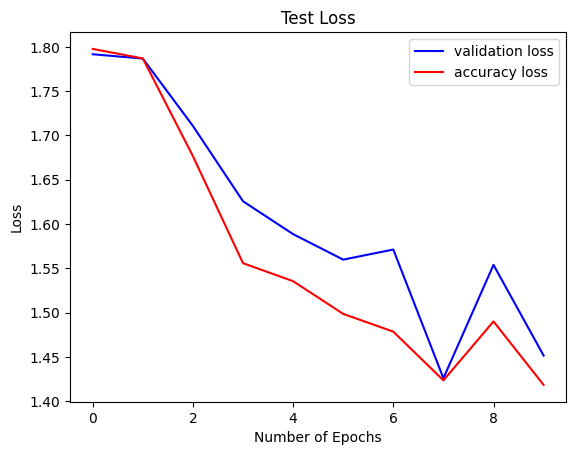

In [94]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Method 2: Transfer Learning from InceptionV3

In [ ]:
import keras
from keras.api.applications.inception_v3 import InceptionV3

EPOCHS = 50
BATCH_SIZE = 256

pre_trained_model = InceptionV3(
    input_shape=X_train.shape[1::],
    weights="imagenet",
    include_top=False,  # the fully connected layer at the end
)

for layer in pre_trained_model.layers:
    layer.trainable = False

fully_connected_layer = keras.layers.Flatten()(pre_trained_model.output)
fully_connected_layer = keras.layers.Dense(512, activation="relu")(fully_connected_layer)
fully_connected_layer = keras.layers.Dropout(0.2)(fully_connected_layer)
fully_connected_layer = keras.layers.Dense(len(classes), activation="softmax")(
    fully_connected_layer
)

transfer_model = keras.Model(pre_trained_model.input, fully_connected_layer)

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), "acc"],
)

history = transfer_model.fit(
    X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, Y_test)
)

In [ ]:
import matplotlib.pyplot as plt

# show the accuracy of method 2
plt.plot(history.history["acc"], color="b", label="accuracy")
plt.title("Accuracy of Transfer Model (Inceptionv3)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# show the training (and validation) loss of method 2
plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
transfer_model.summary()